In [1]:
import pandas as pd
import numpy as np
from datetime import datetime as dt
import matplotlib.pyplot as plt

dates_df = pd.read_excel('data/keyrate_dates.xlsx')
ruonia = pd.read_excel('data/Динамика ставки RUONIA.xlsx', engine='openpyxl').set_axis(['date', 'ruonia'], axis = 1)
roisfix = pd.read_excel('data/Ставка ROISfix (RUONIA Overnight Interest Rate Swap).xlsx', engine='openpyxl').iloc[1:, :]\
    .set_axis(['date', 'ruonia_1w', 'ruonia_2w', 'ruonia_1m', 'ruonia_2m', 'ruonia_3m', 'ruonia_6m', 'ruonia_1y', 'ruonia_2y'], axis = 1).fillna(0.0)
roisfix.iloc[:, 1:] = roisfix.iloc[:, 1:].replace('--', '0', regex=True).replace(',', '.', regex=True).astype(float)
dates = [dt.strptime(i, '%d.%m.%Y') for i in dates_df['date']][:-2]
dates_pairs = [(i, j) for i, j in zip(dates[:-1], dates[1:])]
roisfix['date'] = [dt.strptime(i, '%d-%m-%Y') for i in roisfix['date']]
ruonia['date'] = pd.to_datetime(ruonia['date'])
roisfix = roisfix.sort_values(['date'], ascending=True).reset_index(drop=True).loc[:,['date', 'ruonia_3m', 'ruonia_6m']]
ruonia = ruonia.sort_values(['date'], ascending=True).reset_index(drop=True)
def diffrence(df):
    v = ((df.diff().iloc[1:, 1:])**2).sum().item()
    if v == 0:
        share_of_v = 1
    else:
        share_of_v = ((df.diff().iloc[1:, 1:])**2).iloc[-1].item()/((df.diff().iloc[1:, 1:])**2).sum().item()
    share_of_d = abs(abs((df.iloc[-1, 1:].item() - df.iloc[-2, 1:].item())) - abs((df.iloc[-1, 1:].item() - df.iloc[0, 1:].item())))
    return share_of_v, share_of_d

In [10]:
dates_df

,date
0,14.02.2014
1,03.03.2014
2,14.03.2014
3,25.04.2014
4,16.06.2014
...,...
97,25.04.2025
98,06.06.2025
99,25.07.2025
100,12.09.2025


In [2]:
key_dates = pd.read_excel('data/key_rate.xlsx')
increase_i = [dt.strptime(i, '%d.%m.%Y') for i in key_dates.loc[key_dates.sort_index(ascending=False).rate.diff() > 0, :]['date']]
decrease_i = [dt.strptime(i, '%d.%m.%Y') for i in key_dates.loc[key_dates.sort_index(ascending=False).rate.diff() > 0, :]['date']]
unchange_i = [dt.strptime(i, '%d.%m.%Y') for i in key_dates.loc[key_dates.sort_index(ascending=False).rate.diff() == 0, :]['date']]

In [6]:
data = []
for date in dates_pairs:
    i, j = date
    results = []
    results.append((j-i).days)
    r_now = ruonia.loc[(ruonia['date'] > i) & (ruonia['date'] <= j),:].copy(deep = True).reset_index(drop=True)
    r_now = diffrence(r_now)
    results.append(r_now[0])
    results.append(r_now[1].item())
    r_3m = roisfix.loc[(roisfix['date'] > i) & (roisfix['date'] <= j),:].copy(deep = True).reset_index(drop=True).loc[:, ['date', 'ruonia_3m']]
    r_3m = diffrence(r_3m)
    results.append(r_3m[0])
    results.append(r_3m[1])
    r_6m = roisfix.loc[(roisfix['date'] > i) & (roisfix['date'] <= j),:].copy(deep = True).reset_index(drop=True).loc[:, ['date', 'ruonia_6m']]
    r_6m = diffrence(r_6m)
    results.append(r_6m[0])
    results.append(r_6m[1])
    data += [results]


In [8]:
res_df = pd.DataFrame(data, columns=['days', 'sv_ru0', 'sd_ru0', 'sv_ru3m', 'sd_ru3m', 'sv_ru6m', 'sd_ru6m'])
res_df.describe().set_axis(['Кол-во дней', 'Доля дисперсии RUONIA', 'Доля от линейного изменения RUONIA', 
                            'Доля дисперсии RUONIA 3м', 'Доля от линейного изменения RUONIA 3м',
                            'Доля дисперсии RUONIA 6м', 'Доля от линейного изменения RUONIA 6м'], axis = 1).to_latex()

'\\begin{tabular}{lrrrrrrr}\n\\toprule\n & Кол-во дней & Доля дисперсии RUONIA & Доля от линейного изменения RUONIA & Доля дисперсии RUONIA 3м & Доля от линейного изменения RUONIA 3м & Доля дисперсии RUONIA 6м & Доля от линейного изменения RUONIA 6м \\\\\n\\midrule\ncount & 99.000000 & 99.000000 & 99.000000 & 99.000000 & 99.000000 & 99.000000 & 99.000000 \\\\\nmean & 42.212121 & 0.093137 & 0.309394 & 0.099806 & 0.562323 & 0.103769 & 0.633535 \\\\\nstd & 12.392619 & 0.209009 & 0.389921 & 0.232135 & 0.876093 & 0.243960 & 0.994408 \\\\\nmin & 4.000000 & 0.000000 & 0.000000 & 0.000000 & 0.000000 & 0.000000 & 0.000000 \\\\\n25% & 35.000000 & 0.003323 & 0.105000 & 0.000000 & 0.065000 & 0.000000 & 0.090000 \\\\\n50% & 42.000000 & 0.014999 & 0.210000 & 0.012195 & 0.240000 & 0.007463 & 0.340000 \\\\\n75% & 49.000000 & 0.048110 & 0.425000 & 0.061448 & 0.630000 & 0.069510 & 0.820000 \\\\\nmax & 79.000000 & 1.000000 & 3.010000 & 1.000000 & 5.530000 & 1.000000 & 6.960000 \\\\\n\\bottomrule\n\\end{t

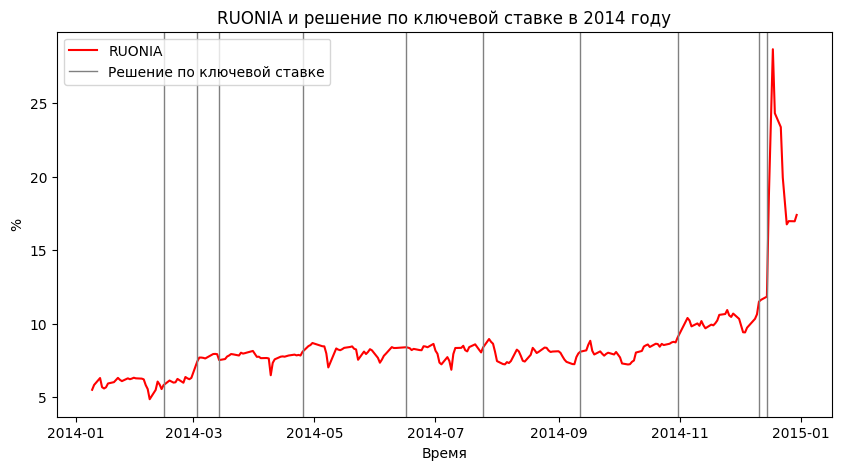

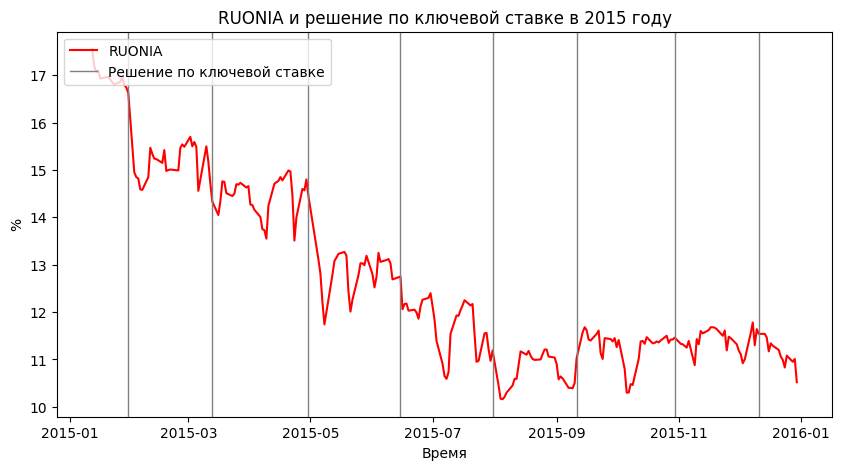

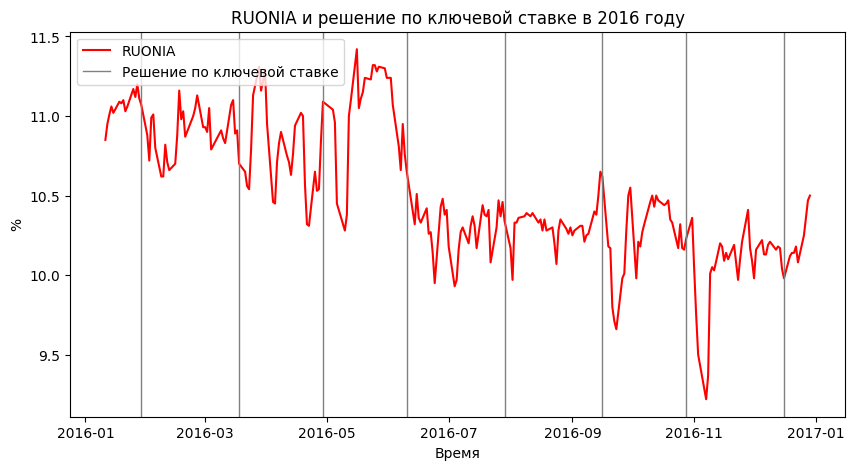

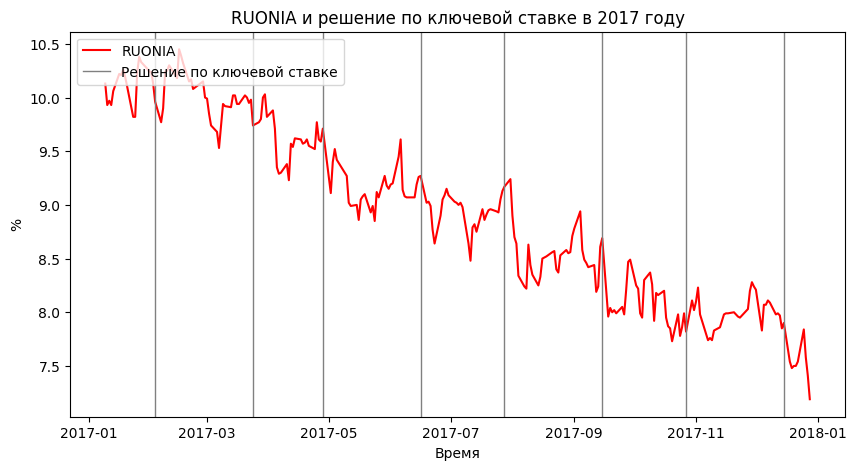

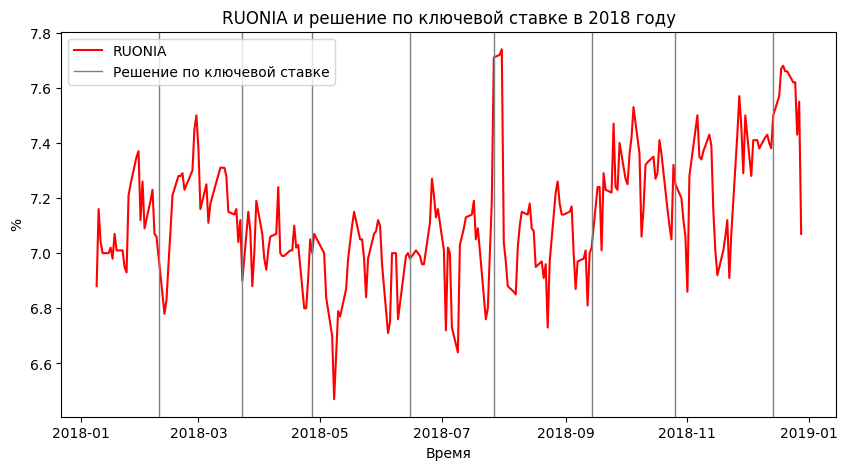

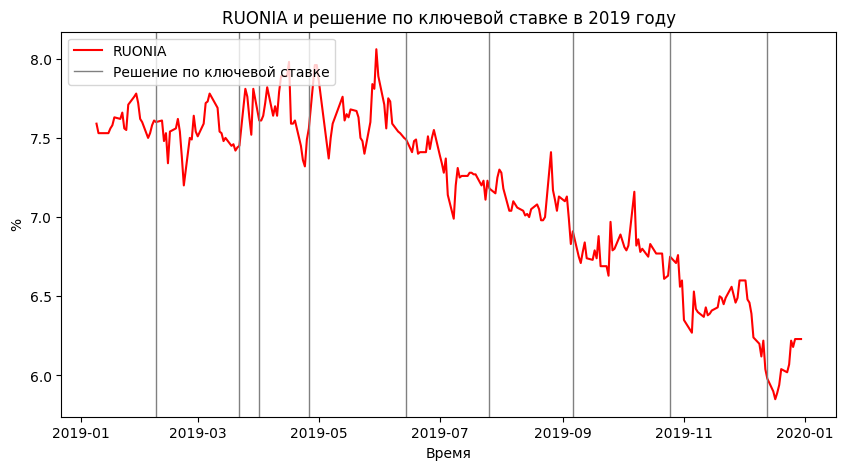

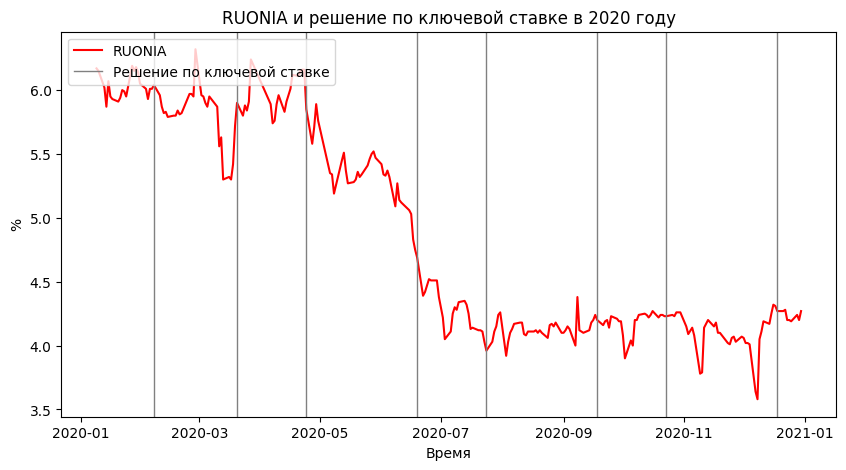

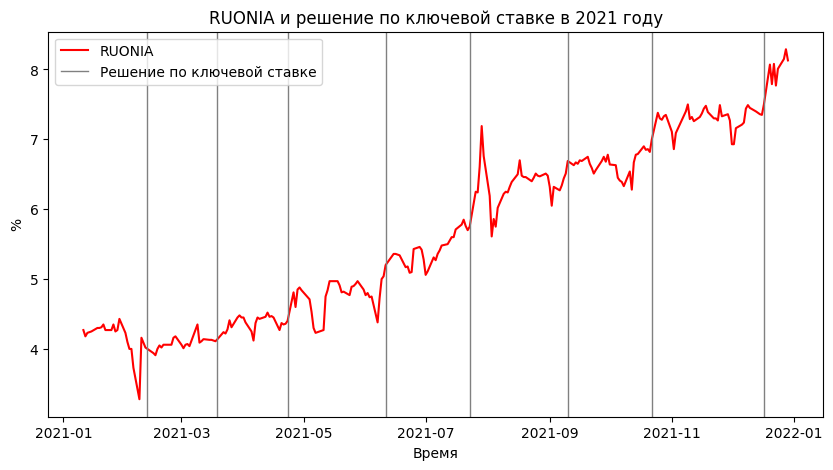

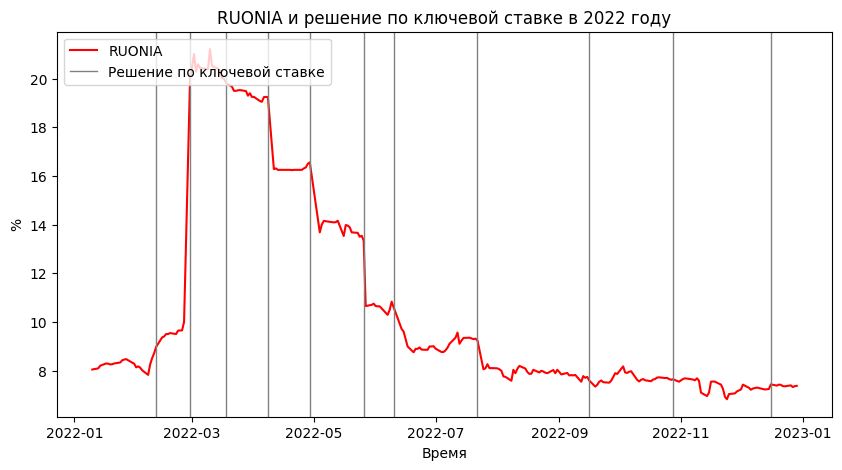

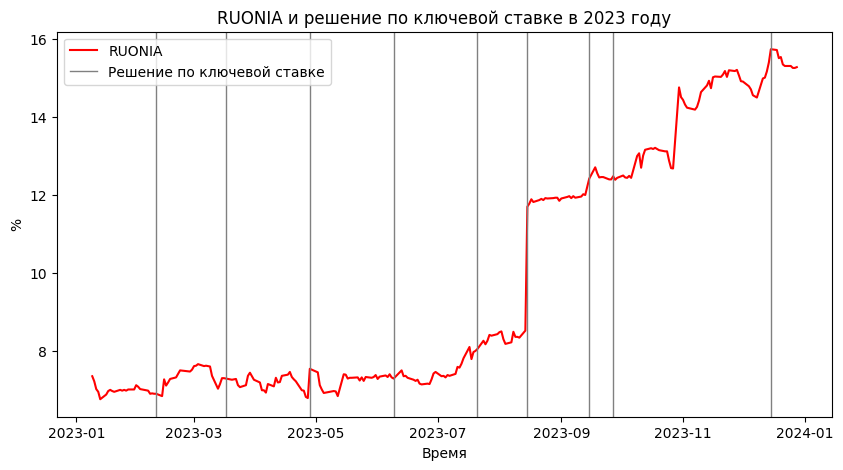

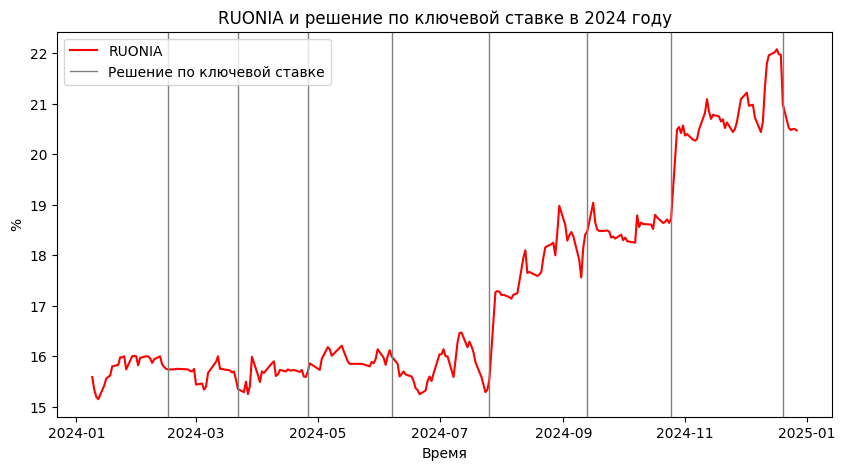

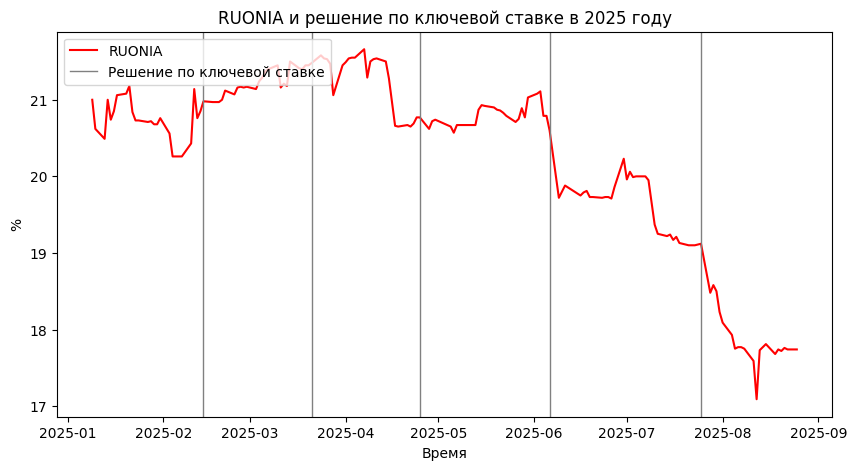

In [6]:
for year in range(2014, 2026):
    i = dt(year = year, month=1, day=1)
    j = dt(year = year+1, month=1, day=1)
    temp_df = ruonia.loc[(ruonia['date'] >= i) & (ruonia['date'] < j),:].copy(deep = True).reset_index(drop=True)
    plt.figure(figsize=(10,5))
    ruonia_plot, = plt.plot(temp_df['date'], temp_df['ruonia'], color='red', label='RUONIA')
    temp_dates = [d for d in dates if d >= i and d < j]
    for date in temp_dates:
        decision_dates = plt.axvline(date, color='grey', lw=1, label = 'Решение по ключевой ставке')
    plt.xlabel("Время")
    plt.ylabel("%")
    plt.legend(handles=[ruonia_plot, decision_dates], loc = 'upper left')
    fig_name = f"RUONIA и решение по ключевой ставке в {year} году"
    plt.title(fig_name)
    
    plt.savefig(f'{fig_name}.jpeg')
    plt.show()

рёня черный
повышение красный
снижение синий
нейтральный серый/желтый

месяца поставить вниц

In [11]:

dates[0] > dt(year = 2014, month=1, day=1) and dates[0] > dt(year = 2015, month=1, day=1)

False

In [22]:
key_dates = pd.read_excel('data/key_rate.xlsx')

In [24]:
key_dates.rate.diff()

0       NaN
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
2973    0.0
2974    0.0
2975    0.0
2976    0.0
2977    0.0
Name: rate, Length: 2978, dtype: float64

In [38]:
increase_i = [dt.strptime(i, '%d.%m.%Y') for i in key_dates.loc[key_dates.sort_index(ascending=False).rate.diff() > 0, :]['date']]
decrease_i = [dt.strptime(i, '%d.%m.%Y') for i in key_dates.loc[key_dates.sort_index(ascending=False).rate.diff() > 0, :]['date']]
unchange_i = [dt.strptime(i, '%d.%m.%Y') for i in key_dates.loc[key_dates.sort_index(ascending=False).rate.diff() == 0, :]['date']]


In [60]:
def diffrence(df):
    share_of_v = ((df.diff().iloc[1:, 1:])**2).iloc[-1].item()/((df.diff().iloc[1:, 1:])**2).sum().item()
    share_of_d = abs((df.iloc[-1, 1:].item() - df.iloc[-2, 1:].item()))/abs((df.iloc[-1, 1:].item() - df.iloc[0, 1:].item()))
    return share_of_v, share_of_d

In [62]:
diffrence(r_6m)

(0.9961368653421634, 0.9134615384615385)

In [31]:
((temp_df.diff().iloc[1:, 1:])**2).iloc[-1].item()/((temp_df.diff().iloc[1:, 1:])**2).sum().item()

0.8056518946692358

In [ ]:

((temp_df.iloc[-1, 1:].item() - temp_df.iloc[-2, 1:].item())/(temp_df.iloc[-1, 1:].item() - temp_df.iloc[0, 1:].item())).item()

ValueError: can only convert an array of size 1 to a Python scalar

In [38]:
(j-i).days

17

In [55]:
temp_df = roisfix.loc[(roisfix['date'] > i) & (roisfix['date'] <= j),:].copy(deep = True).reset_index(drop=True)

In [56]:
temp_df.diff().iloc[1:, 1:]

,ruonia_3m,ruonia_6m
1,0.0,0.0
2,0.02,0.0
3,0.03,0.04
4,-0.01,0.0
5,-0.01,-0.01
6,0.0,-0.01
7,0.01,0.02
8,0.01,0.02
9,0.04,0.03
10,0.93,0.95


In [52]:
temp_df

,date,ruonia_1w,ruonia_2w,ruonia_1m,ruonia_2m,ruonia_3m,ruonia_6m,ruonia_1y,ruonia_2y
0,2014-02-17,6.12,6.2,6.25,6.26,6.32,6.34,0.0,0.0
1,2014-02-18,6.11,6.2,6.25,6.27,6.32,6.34,0.0,0.0
2,2014-02-19,6.16,6.21,6.26,6.29,6.34,6.34,0.0,0.0
3,2014-02-20,6.18,6.24,6.28,6.32,6.37,6.38,0.0,0.0
4,2014-02-21,6.22,6.25,6.29,6.32,6.36,6.38,0.0,0.0
5,2014-02-24,6.22,6.24,6.28,6.31,6.35,6.37,0.0,0.0
6,2014-02-25,6.23,6.25,6.27,6.3,6.35,6.36,0.0,0.0
7,2014-02-26,6.24,6.26,6.27,6.32,6.36,6.38,0.0,0.0
8,2014-02-27,6.2,6.22,6.27,6.32,6.37,6.4,0.0,0.0
9,2014-02-28,6.24,6.24,6.3,6.36,6.41,6.43,0.0,0.0
